In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import json

# SSL for emotion analysis
#### 25.11.2020

## Proposal plan

- [x] 1.Setting up the environment
- [x] 2.Corpora preprocessing
- [x] 3.Unlabeled data collecting & cleaning
- [x] 4.Baseline model
- [ ] 5.Semi-supervised Sequence Learning (SSL Model 1) [https://arxiv.org/abs/1511.01432] (Poor performance)

## Dataset Preparation
- Tokenize by spaCy library and removed NLTK's stopwords
- Made statistics and generate vocabularies for tokens have dominate class trendency. (Threshold at 40%, 60%，80% for top two classes)

For SSEC:
- Removed @usernames and URLs.
- Replaced emojis like :) to special marks and added specail cases to tokenizer.
- Used the labels with highest possible agreement, but without losing labels.

For TEC:
- Cleaned Twitter things just same as in SSEC.
- Removed non-English samples.
- (Optinal) Data augmentation with textaugment library, deal with the unbalance of classes.

For ISEAR:
- Handles special samples in the dataset e.g. \[No response.\]


ISEAR sample:
['When', 'I', 'driving', 'home', 'several', 'days', 'hard', 'work', 'motorist', 'ahead', 'driving', '50', 'km', 'hour', 'refused', 'despite', 'low', 'speeed', 'let', 'overtake'] [3]
ISEAR most frequency tokens:


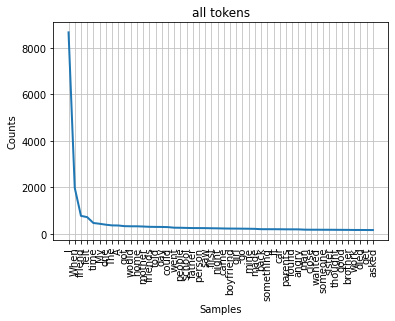

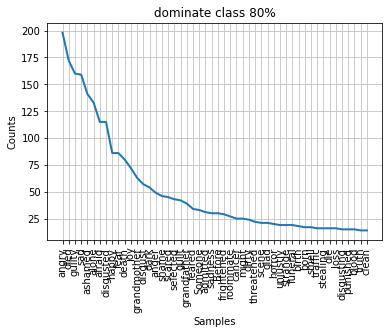

<AxesSubplot:title={'center':'dominate class 80%'}, xlabel='Samples', ylabel='Counts'>

In [2]:
import pre.load_data as load_data
tec_data, isear_data, ssec_data = load_data.load_data()
print('ISEAR sample:')
print(isear_data.get_data()[1], isear_data.get_target()[1])

freq_dist_nltk_0, freq_dist_nltk_40, freq_dist_nltk_60, freq_dist_nltk_80 = load_data.get_freq_plot('isear')
print('ISEAR most frequency tokens:')
freq_dist_nltk_0.plot(50, cumulative=False, title="all tokens")
freq_dist_nltk_80.plot(50, cumulative=False, title="dominate class 80%")

## Unlabeled Data

### 1.Twitter Data
Take a similar approach to TEC. 
Crawled 10000 tweets that have hashtags with emotions.
Filtered out non-English tweets, about 6000-8000 left for each class.
Then clean them up using the preceding Tokenizer.

Can be used by TEC and SSEC.

### 2.Story Data
Crawled stories form [https://sayitforward.org/stories/].
802 Stories, 34151 sentences. 

Can be used by ISEAR.

### 3.EmoEvent (Not really unlabeled)
From paper:

EmoEvent: A Multilingual Emotion Corpus based on different Events [https://www.aclweb.org/anthology/2020.lrec-1.186/]

The dataset has 7303 English tweets that based on different events and have emotions.

Can be used by SSEC, TEC and ISEAR.


## Baseline Model

Baseline model are LSTM models, consist of:
- Fasttext embedding matrix
- Bidirectional LSTM layer
- 2 Dense layers
- Softmax for ISEAR and TEC, Sigmoid for SSEC


## SSL Model
SSL model consist of a LSTM Language model and a LSTM classifier.

The classifier has the same architecture as the baseline.

The language model has a embedding layer and a LSTM layer, followed by a dense layer as decoder.
The size of embedding matrix and LSTM weight of classifier and LM are same.

We firstly train a LM from unlabeled+labeled dataset, then load the weight into classifier.
Finally train the classifier normally.



# Issues in the models

## 1. Small datasets and overfitting

## 2. SSL does not work well in emotion corpora

### a. Crawled unlabeled data low quality

### b. Datasets itself low quality

## 3. How to deal with non emotional unlabeled data